## **Question 1**

### FTRL with Quadratic Regularization

In [5]:
# Importing Required Packages

import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [6]:
T = 10000

dataset = []
with open ('Dataset_Z.txt', 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        values = [float(x) for x in line.split(',')]
        dataset.append(values)

dataset = np.array(dataset)

In [7]:
# An algorithm to project a vector onto the simplex using sorting
# Found upon research, understood and implemented

def simplex_proj(p):
    dim = p.shape[0]
    u = np.sort(p)[::-1]
    ind = np.arange(dim) + 1
    t = u + (1 - np.cumsum(u))/ind
    rho = np.where(t>0,1,0).sum()
    lmbd = (1 - np.sum(u[:rho]))/rho
    x = np.array([max(p[i]+lmbd,0) for i in range(dim)])
    return x

In [8]:
d = 1000

wt = np.ones(d)
pt = np.abs(wt)/norm(wt, 1)

L = max(norm(dataset, axis=1))  # Upper bound on adversary loss vector norm
B = 1           # Upper bound on selected pt's norms (Simplex, therefore 1)

# Storing the cumulative loss vectors to easily find best expert in hindsight
cum_zt = np.cumsum(dataset, axis=0)

# eta according to FTRL with quadratic regularization
eta = B/(L*np.sqrt(2*T))

cum_algo_loss = 0
regret_quad = []

for t in range(T):  

    zt = dataset[t]

    loss = np.dot(pt, zt)

    cum_algo_loss += loss
    best_expert_loss = np.min(cum_zt[t])

    # FTRL-quadratic update + projection onto simplex
    pt = pt - eta*zt
    pt = simplex_proj(pt)

    regret_quad.append(cum_algo_loss - best_expert_loss)

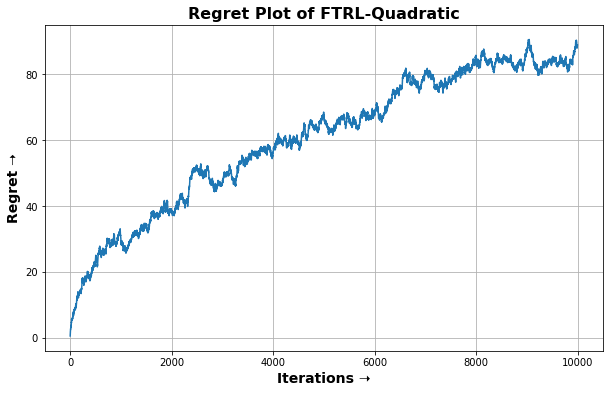

In [9]:
plt.figure(figsize=(10,6))
plt.plot(range(T), regret_quad)
plt.grid(True)
plt.title("Regret Plot of FTRL-Quadratic", fontweight = 'bold', fontsize = 16)
plt.xlabel("Iterations \u279d", fontweight = 'bold', fontsize = 14)
plt.ylabel("Regret \u279d", fontweight = 'bold', fontsize = 14)
plt.show()

### Entropic Regularization

In [10]:
d = 1000

wt = np.ones(d)
# Uniform initialisation
pt = np.abs(wt)/norm(wt, 1)

# Upper bound on adversary loss vector norms
B = max(norm(dataset, axis=1))

# Storing the cumulative loss vectors to easily find best expert in hindsight
cum_zt = np.cumsum(dataset, axis=0)

# eta according to FTRL with entropic regularization
eta = np.sqrt(np.log(d)/(T*B**2))

cum_algo_loss = 0
regret_entr = []

for t in range(T):  

    zt = dataset[t]

    loss = np.dot(pt, zt)

    cum_algo_loss += loss
    best_expert_loss = np.min(cum_zt[t])

    # FTRL-entropic (Hedge) update rule
    wt = wt*np.exp(-eta*zt)
    pt = wt/norm(wt, 1)

    regret_entr.append(cum_algo_loss - best_expert_loss)


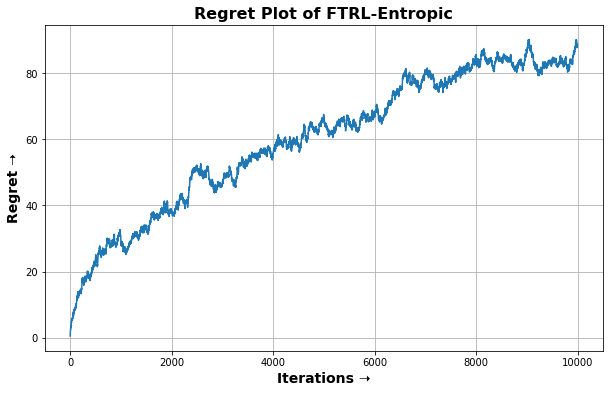

In [11]:
plt.figure(figsize=(10,6))
plt.plot(range(T), regret_entr)
plt.grid(True)
plt.title("Regret Plot of FTRL-Entropic", fontweight = 'bold', fontsize = 16)
plt.xlabel("Iterations \u279d", fontweight = 'bold', fontsize = 14)
plt.ylabel("Regret \u279d", fontweight = 'bold', fontsize = 14)
plt.show()

### FTL with Randomization

In [12]:
d = 1000

wt = np.ones(d)
pt = np.abs(wt)/norm(wt, 1)

B = max(norm(dataset, axis=1))

# Storing the cumulative loss vectors to easily find best expert in hindsight
cum_zt = np.cumsum(dataset, axis=0)

# eta according to FTL with Randomization
eta = np.sqrt(2/(d*T))

# Fixing the random vector R
R = np.random.uniform(low = 0, high = 1/eta, size = d)

cum_algo_loss = 0
regret_fpl = []

for t in range(T):  

    zt = dataset[t]

    loss = np.dot(pt, zt)

    cum_algo_loss += loss
    best_expert_loss = np.min(cum_zt[t])

    # FTL with randomization update rule
    pt = (cum_zt[t] + R)==min(cum_zt[t]+R)

    regret_fpl.append(cum_algo_loss - best_expert_loss)


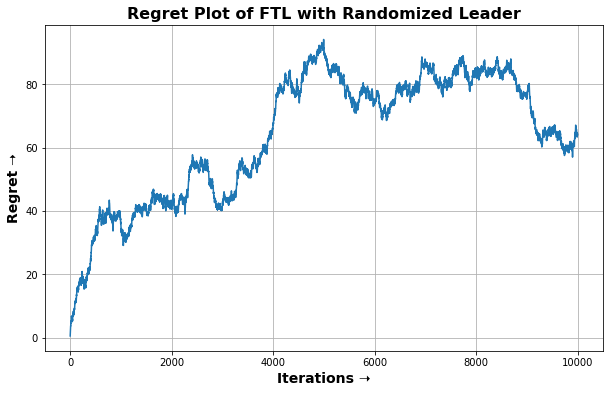

In [13]:
plt.figure(figsize=(10,6))
plt.plot(range(T), regret_fpl)
plt.grid(True)
plt.title("Regret Plot of FTL with Randomized Leader", fontweight = 'bold', fontsize = 16)
plt.xlabel("Iterations \u279d", fontweight = 'bold', fontsize = 14)
plt.ylabel("Regret \u279d", fontweight = 'bold', fontsize = 14)
plt.show()

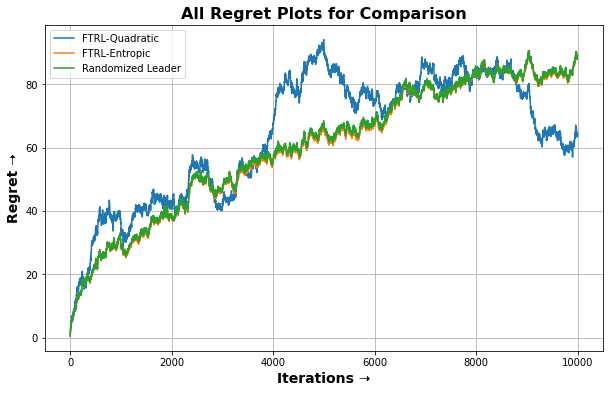

In [14]:
# PLOTTING ALL REGRET CURVES TOGETHER

plt.figure(figsize=(10,6))
plt.plot(range(T), regret_fpl, label = "FTRL-Quadratic")
plt.plot(range(T), regret_entr, label = "FTRL-Entropic")
plt.plot(range(T), regret_quad, label = "Randomized Leader")
plt.grid(True)
plt.legend()
plt.title("All Regret Plots for Comparison", fontweight = 'bold', fontsize = 16)
plt.xlabel("Iterations \u279d", fontweight = 'bold', fontsize = 14)
plt.ylabel("Regret \u279d", fontweight = 'bold', fontsize = 14)
plt.show()

## **Question 2**

In [15]:
# Importing Required Packages

from scipy.stats import beta
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [16]:
iters = T = 10000
runs = 1000

num_arms = d = 10
# eta according to EXP3
eta = np.sqrt(2*np.log(d)/(T*d))

# 2D array to store regrets across time for all 1000 runs
runs_regrets = np.zeros((runs, iters))

for run in range(runs):
    wt = np.ones(num_arms)
    cum_losses = np.zeros(num_arms)

    cum_algo_loss = 0

    # Generating the beta distribution vectors for all time instants
    losses = np.hstack((beta.rvs(a=5, b=5, size=(T, num_arms-1)), beta.rvs(a=5, b=10, size=(T,1))))

    for iter in range(iters):
        pt = wt/norm(wt, 1)
        loss_vector = losses[iter]
        # Storing cumulative losses to find best expert in hindsight
        cum_losses += loss_vector

        # Choosing an arm according to pt as a probability distribution
        arm_choice = np.random.choice(num_arms, p = pt)
        lt_it = loss_vector[arm_choice]
        pt_it = pt[arm_choice]

        # Generating "fake" loss vector for the Hedge within EXP3
        lt_hat = np.zeros(num_arms)
        lt_hat[arm_choice] = lt_it/pt_it

        # EXP3 update
        wt = wt*np.exp(-eta*lt_hat)

        # Cumulative algorithm loss
        cum_algo_loss += np.dot(loss_vector, pt)

        best_expert_loss = np.min(cum_losses)

        # Storing regret
        runs_regrets[run, iter] = cum_algo_loss - best_expert_loss

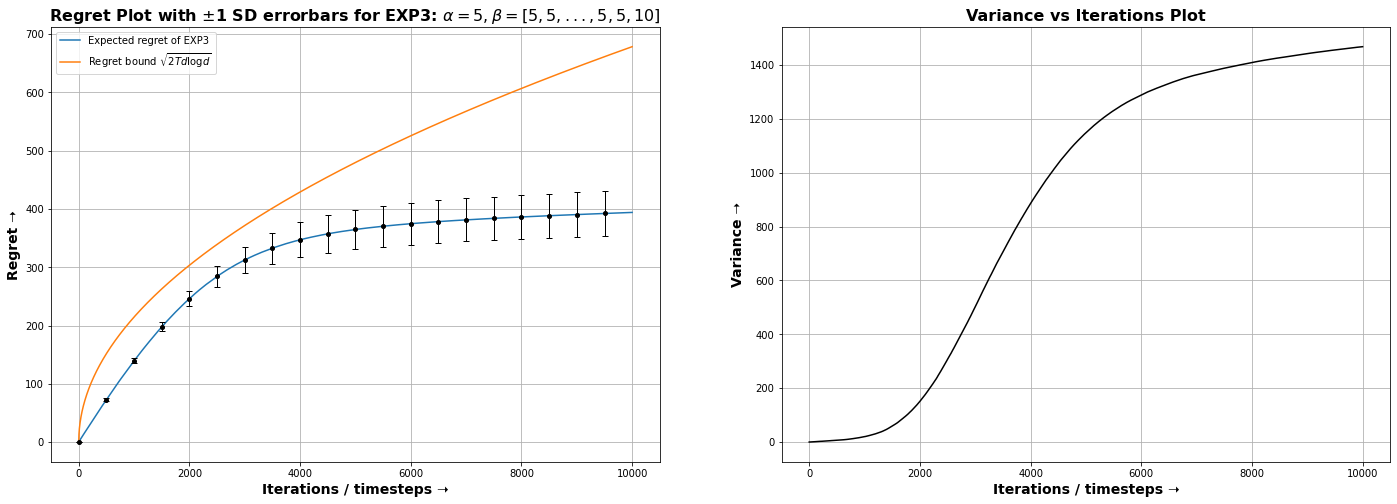

In [17]:
# Plotting with errorbars

d=10

runs_regrets_mean = np.mean(runs_regrets, axis = 0)
runs_regrets_std = np.std(runs_regrets, axis = 0)

x_axis = range(iters)
step = 500

fig, ax = plt.subplots(1, 2, figsize = (24, 8))
ax[0].set_title(r"Regret Plot with $\pm$1 SD errorbars for EXP3: $\alpha = 5, \beta = [5,5,...,5,5,10]$", fontsize = 16, fontweight = 'bold')
ax[0].plot(x_axis, runs_regrets_mean, label = "Expected regret of EXP3")
ax[0].errorbar(x_axis[::step], runs_regrets_mean[::step], runs_regrets_std[::step], fmt='ko', linewidth = 1, markersize=4, capsize=3)
ax[0].grid(True)
ax[0].set_xlabel("Iterations / timesteps \u279d", fontweight = 'bold', fontsize = 14)
ax[0].set_ylabel("Regret \u279d", fontweight = 'bold', fontsize = 14)
ax[0].plot(range(T), np.sqrt(2*np.arange(T)*d*np.log(d)), label = r"Regret bound $\sqrt{2Td\log{d}}$")
ax[0].legend()

ax[1].set_title(r"Variance vs Iterations Plot", fontsize = 16, fontweight = 'bold')
ax[1].plot(x_axis, runs_regrets_std**2, 'k')
ax[1].grid(True)
ax[1].set_xlabel("Iterations / timesteps \u279d", fontweight = 'bold', fontsize = 14)
ax[1].set_ylabel("Variance \u279d", fontweight = 'bold', fontsize = 14)

plt.show()


## **Question 3**

In [18]:
# Importing required packages

from scipy.stats import beta
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [19]:
iters = T = 10000
runs = 50 #00

num_arms = d = 10
eta = np.sqrt(2*np.log(d)/(T*d))

# Function to perform eps-greedy
def egreedy(eps):
    runs_regrets_egreedy = np.zeros((runs, iters))
    for run in range(runs):

        avg_reward = np.zeros(num_arms)
        arm_counts = np.zeros(num_arms)

        cum_rewards = np.zeros(num_arms)
        cum_algo_reward = 0

        for iter in range(iters):
            # Generating reward vector
            rew_vector = beta.rvs(a=5, b=np.linspace(5, 5*num_arms, num_arms))
            # Storing cumulative rewards to get best arm in hindsight
            cum_rewards += rew_vector

            # Best arm based on average reward
            best_arm = np.argmax(avg_reward)

            # eps-greedy selection
            eps_sampler = np.random.uniform()
            if eps_sampler < eps:
                arm_choice = np.random.choice(num_arms)
            else:
                arm_choice = best_arm

            arm_counts[arm_choice] += 1
            obs_reward = rew_vector[arm_choice]
            # Updating average reward
            avg_reward[arm_choice] += (obs_reward-avg_reward[arm_choice])/arm_counts[arm_choice]

            best_arm_reward = np.max(cum_rewards)
            cum_algo_reward += obs_reward

            # Storing regret
            runs_regrets_egreedy[run, iter] = best_arm_reward - cum_algo_reward
        
    return runs_regrets_egreedy

runs_regrets_egr_001 = egreedy(eps=0.01)
runs_regrets_egr_003 = egreedy(eps=0.03)
runs_regrets_egr_01 = egreedy(eps=0.1)
runs_regrets_egr_03 = egreedy(eps=0.3)

In [20]:
# Similarly running EXP3 and Round-Robin Greedy

runs_regrets_exp3 = np.zeros((runs, iters))
runs_regrets_greedy = np.zeros((runs, iters))

for run in range(runs):

    # Greedy

    avg_reward = np.zeros(num_arms)
    arm_counts = np.zeros(num_arms)
    cum_rewards = np.zeros(num_arms)
    cum_algo_reward = 0

    # EXP3

    wt = np.ones(num_arms)
    cum_losses = np.zeros(num_arms)

    cum_pt_loss = 0

    for iter in range(iters):

        # Greedy

        rew_vector = beta.rvs(a=5, b=np.linspace(5, 5*num_arms, num_arms))
        cum_rewards += rew_vector

        # Choose all arms first before selecting greedily
        if iter < num_arms:
            arm_choice = iter
        else:
            # Select greedily
            arm_choice = np.argmax(avg_reward)
        
        arm_counts[arm_choice] += 1

        obs_reward = rew_vector[arm_choice]
        # Update average reward
        avg_reward[arm_choice] += (obs_reward-avg_reward[arm_choice])/arm_counts[arm_choice]

        best_arm_reward = np.max(cum_rewards)
        cum_algo_reward += obs_reward
        # Storing regret
        runs_regrets_greedy[run, iter] = best_arm_reward - cum_algo_reward
        
        # EXP3

        pt = wt/norm(wt, 1)
        loss_vector = 1-rew_vector
        cum_losses += loss_vector

        arm_choice = np.random.choice(num_arms, p = pt)
        lt_it = loss_vector[arm_choice]
        pt_it = pt[arm_choice]

        lt_hat = np.zeros(num_arms)
        lt_hat[arm_choice] = lt_it/pt_it

        wt = wt*np.exp(-eta*lt_hat)

        cum_pt_loss += np.dot(loss_vector, pt)

        best_arm_loss = np.min(cum_losses)
        runs_regrets_exp3[run, iter] = cum_pt_loss - best_arm_loss


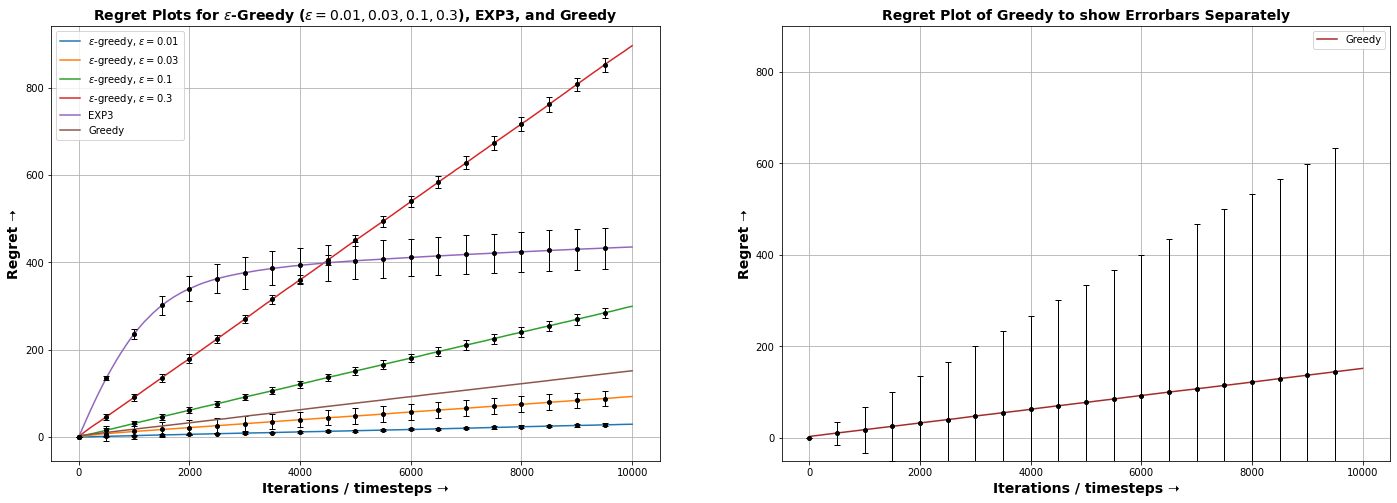

In [21]:
# Plotting all regret curves with errorbars

runs_regrets_egr_001_mean = np.mean(runs_regrets_egr_001, axis = 0)
runs_regrets_egr_001_std = np.std(runs_regrets_egr_001, axis = 0)
runs_regrets_egr_003_mean = np.mean(runs_regrets_egr_003, axis = 0)
runs_regrets_egr_003_std = np.std(runs_regrets_egr_003, axis = 0)
runs_regrets_egr_01_mean = np.mean(runs_regrets_egr_01, axis = 0)
runs_regrets_egr_01_std = np.std(runs_regrets_egr_01, axis = 0)
runs_regrets_egr_03_mean = np.mean(runs_regrets_egr_03, axis = 0)
runs_regrets_egr_03_std = np.std(runs_regrets_egr_03, axis = 0)

runs_regrets_exp3_mean = np.mean(runs_regrets_exp3, axis = 0)
runs_regrets_exp3_std = np.std(runs_regrets_exp3, axis = 0)

runs_regrets_greedy_mean = np.mean(runs_regrets_greedy, axis = 0)
runs_regrets_greedy_std = np.std(runs_regrets_greedy, axis = 0)


x_axis = range(iters)
step = 500

fig, ax = plt.subplots(1, 2, figsize=(24,8))
ax[0].plot(x_axis, runs_regrets_egr_001_mean, label="$\epsilon$-greedy, $\epsilon=0.01$")
ax[0].errorbar(x_axis[::step], runs_regrets_egr_001_mean[::step], runs_regrets_egr_001_std[::step], fmt='ko', linewidth = 1, markersize=4, capsize=3)

ax[0].plot(x_axis, runs_regrets_egr_003_mean, label="$\epsilon$-greedy, $\epsilon=0.03$")
ax[0].errorbar(x_axis[::step], runs_regrets_egr_003_mean[::step], runs_regrets_egr_003_std[::step], fmt='ko', linewidth = 1, markersize=4, capsize=3)

ax[0].plot(x_axis, runs_regrets_egr_01_mean, label="$\epsilon$-greedy, $\epsilon=0.1$")
ax[0].errorbar(x_axis[::step], runs_regrets_egr_01_mean[::step], runs_regrets_egr_01_std[::step], fmt='ko', linewidth = 1, markersize=4, capsize=3)

ax[0].plot(x_axis, runs_regrets_egr_03_mean, label="$\epsilon$-greedy, $\epsilon=0.3$")
ax[0].errorbar(x_axis[::step], runs_regrets_egr_03_mean[::step], runs_regrets_egr_03_std[::step], fmt='ko', linewidth = 1, markersize=4, capsize=3)

ax[0].plot(x_axis, runs_regrets_exp3_mean, label ="EXP3")
ax[0].errorbar(x_axis[::step], runs_regrets_exp3_mean[::step], runs_regrets_exp3_std[::step], fmt='ko', linewidth = 1, markersize=4, capsize=3)

ax[0].plot(x_axis, runs_regrets_greedy_mean, label ="Greedy")
#ax[0].errorbar(x_axis[::step], runs_regrets_greedy_mean[::step], runs_regrets_greedy_std[::step], fmt='ko', linewidth = 1, markersize=4, capsize=3)

#plt.xlim(0,100)
#plt.ylim(0,100)
ax[0].grid(True)
ax[0].legend()
ax[0].set_title(r"Regret Plots for $\epsilon$-Greedy ($\epsilon = {0.01, 0.03, 0.1, 0.3}$), EXP3, and Greedy", fontweight = 'bold', fontsize = 14)
ax[0].set_xlabel("Iterations / timesteps \u279d", fontweight = 'bold', fontsize = 14)
ax[0].set_ylabel("Regret \u279d", fontweight = 'bold', fontsize = 14)

ax[1].plot(x_axis, runs_regrets_greedy_mean, label ="Greedy", color='brown')
ax[1].errorbar(x_axis[::step], runs_regrets_greedy_mean[::step], runs_regrets_greedy_std[::step], fmt='ko', linewidth = 1, markersize=4, capsize=3)
ax[1].grid(True)
ax[1].legend()
ax[1].set_ylim(-50,900)
ax[1].set_title(r"Regret Plot of Greedy to show Errorbars Separately", fontweight = 'bold', fontsize = 14)
ax[1].set_xlabel("Iterations / timesteps \u279d", fontweight = 'bold', fontsize = 14)
ax[1].set_ylabel("Regret \u279d", fontweight = 'bold', fontsize = 14)


plt.show()


_____________________________________________________________